# 1. Problem Formulation
Our task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages! 

# 2. Import libraries

In [1]:
# 匯入套件
import os
import numpy as np # 線性運算
import pandas as pd #處理資料
from transformers import BertTokenizer, TFBertModel # 語言模型
import matplotlib.pyplot as plt # 畫圖
import seaborn as sns # 畫圖
import tensorflow as tf # 類神經網路

In [2]:
os.environ["WANDB_API_KEY"] = "0" # to silence warning

# 3. Turn on TPU
TPUs are powerful hardware accelerators specialized in deep learning tasks, including Natural Language Processing. Kaggle provides all users TPU Quota at no cost, which you can use to explore this competition. 

In [3]:
#偵測錯誤
try:                                                                  # 使用 try，測試內容是否正確
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:                                                    # 如果 try 的內容發生錯誤，就執行 except 裡的內容
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


# 3. Read data

In [4]:
# 導入資料
# df_train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
# df_test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

df_train = pd.read_csv('../../Data/contradictory-my-dear-watson/train.csv')
df_test  = pd.read_csv('../../Data/contradictory-my-dear-watson/test.csv')

In [5]:
df_train.head(7) # check data (first 7 rows) 顯示前七行

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
5,ed7d6a1e62,"Bir çiftlikte birisinin, ağıla kapatılmış bu ö...",Çiftlikte insanlar farklı terimler kullanırlar.,tr,Turkish,0
6,5a0f4908a0,ریاست ہائے متحدہ امریکہ واپس آنے پر، ہج ایف بی...,ہیگ کی تفتیش ایف بی آئی اہلکاروں کی طرف سے کی...,ur,Urdu,0


In [6]:
df_test.head(7) # check data (first 7 rows) 顯示前七行

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian
5,aa2510d454,His family had lost a son and a daughter now.,The son and daughter had lost their father.,en,English
6,865d1c7b16,Steps are initiated to allow program board mem...,There's enough room for 35-40 positions on the...,en,English


In [7]:
df_train.shape # check data 總共有多少行與列

(12120, 6)

In [8]:
df_test.shape # check data 總共有多少行與列

(5195, 5)

Let's check some rows more in more detailed way. As example, I'll use the row with 0 index.

- **Premise** - a previous statement or proposition from which another is inferred or follows as a conclusion.
- **Hypothesis** - a supposition or proposed explanation made on the basis of limited evidence as a starting point for further investigation.

In [9]:
# "premise" column
df_train["premise"].values[0] # colume"premise"中的第一個row

'and these comments were considered in formulating the interim rules.'

In [10]:
# "hypothesis" column
df_train["hypothesis"].values[0] #colume"hypothesis"中的第一個row

'The rules developed in the interim were put together with these comments in mind.'

# 3. Vizualize data
Here we can build some plots and visualizations.

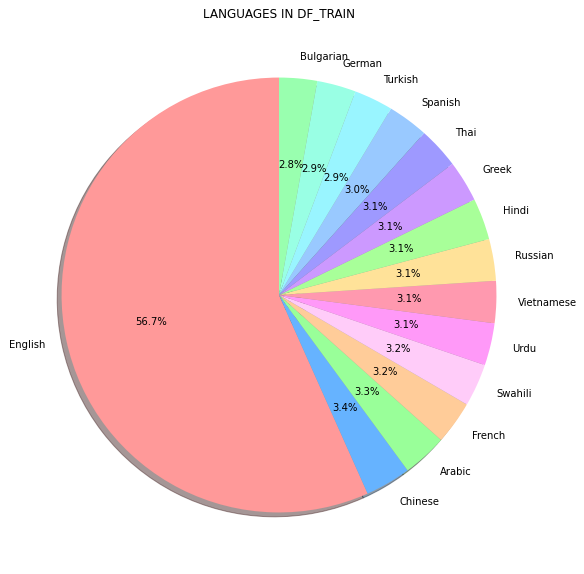

In [11]:
# 畫圖
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
count_classes = df_train['language'].value_counts() # count sentenses in each language
plt.title("Languages in df_train".upper())
colors = ['#ff9999','#66b3ff','#99ff99',
          '#ffcc99', '#ffccf9', '#ff99f8', 
          '#ff99af', '#ffe299', '#a8ff99',
          '#cc99ff', '#9e99ff', '#99c9ff',
          '#99f5ff', '#99ffe4', '#99ffaf']

plt.pie(count_classes, 
        labels = count_classes.index, 
        autopct='%1.1f%%',
        shadow=True, 
        startangle=90, 
        colors=colors)

plt.show()

After that, we can build some more stats:

In [12]:
# 建立函數，方便畫圖
def plot_stats(df, column, ax, color, angle):
    """ PLOT STATS OF DIFFERENT COLUMNS """
    count_classes = df[column].value_counts()
    ax = sns.barplot(x=count_classes.index, y=count_classes, ax=ax, palette=color)
    ax.set_title(column.upper(), fontsize=18)
    for tick in ax.get_xticklabels():
        tick.set_rotation(angle)

Here we can see stats for **"label"**:

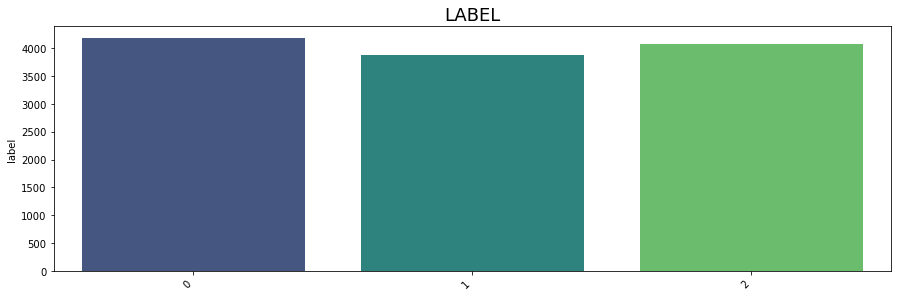

In [13]:
# 使用函數來畫圖
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
fig.autofmt_xdate()
plot_stats(df_train, "label", axes, "viridis", 45)
plt.show()

# 4. Download pretrained models
To start out, we can use a pretrained model. Here, we'll use a multilingual BERT model from huggingface. For more information about BERT, see [here](https://github.com/google-research/bert/blob/master/multilingual.md).

## 4.1 Download tokenizer
Tokenizers turn sequences of words into arrays of numbers. 

In [14]:
model_name = 'bert-base-multilingual-cased' 
tokenizer = BertTokenizer.from_pretrained(model_name) # 匯入已訓練過的語言模型

In [15]:
len(tokenizer.vocab) # check the vocabulary size 總長度

119547

Let's check the tokenizer. As example, we can take the sentence **"you know they can't really defend themselves"**.

The model expects its two inputs sentences to be concatenated together. This input is expected to start with a [CLS] "This is a classification problem" token, and each sentence should end with a [SEP] "Separator" token.

In [16]:
#建立函數，將句子中的字轉成連續性的向量
def encode_sentence(s):
    """ ENCODE SENTENCES WITH TOKENIZER"""
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [17]:
encode_sentence("you know they can't really defend themselves")

[13028, 21852, 10689, 10944, 112, 188, 30181, 60041, 20182, 102]

## 4.2 BERT
[BERT](https://huggingface.co/transformers/model_doc/bert.html#tfbertmodel) **uses three kind of input data** - input word IDs, input masks, and input type IDs.

These allow the model to know that **the premise and hypothesis are distinct sentences**, and also to ignore any padding from the tokenizer.

We add a [CLS] token to denote **the beginning of the inputs**, and a [SEP] token to denote the separation between **the premise and the hypothesis**. 

We also **need to pad** all of the inputs to be the same size.

Now, we're going to **encode all of our premise/hypothesis pairs** for input into BERT.

In [18]:
#建立函數，將輸入所有輸入的長度轉為一樣長
def bert_encode(hypotheses, premises, tokenizer):
    """ ENCODE DATA FOR BERT"""
    num_examples = len(hypotheses)
    print("num_examples = ", num_examples)
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    print("sentence1.shape = ", sentence1.shape)
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])
    print("sentence2.shape = ", sentence2.shape)
    cls_ = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * sentence1.shape[0]
    input_word_ids = tf.concat([cls_, sentence1, sentence2], axis=-1)
    print("input_word_ids.shape = ", input_word_ids.shape)
    # 300 - as my example
    # because we have train_input (12120; 259), test_input (5159; 234)
    # and shape[1] should be the same in each dataset
    # that is why we creating (xxx; 300) shape in to_tensor() functions  
    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(input_word_ids.shape[0], 300)) 
    print("input_mask.shape = ", input_mask.shape)
    
    type_cls = tf.zeros_like(cls_)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=(input_word_ids.shape[0], 300))
    
    inputs = {'input_word_ids': input_word_ids.to_tensor(shape=(input_word_ids.shape[0], 300)),
              'input_mask': input_mask,
              'input_type_ids': input_type_ids}
    print()
    
    return inputs
    

In [19]:
# encode data
train_input = bert_encode(df_train["premise"].values, df_train["hypothesis"].values, tokenizer)
test_input = bert_encode(df_test["premise"].values, df_test["hypothesis"].values, tokenizer)

num_examples =  12120
sentence1.shape =  (12120, None)
sentence2.shape =  (12120, None)
input_word_ids.shape =  (12120, None)
input_mask.shape =  (12120, 300)

num_examples =  5195
sentence1.shape =  (5195, None)
sentence2.shape =  (5195, None)
input_word_ids.shape =  (5195, None)
input_mask.shape =  (5195, 300)



In [20]:
train_input # check train input 顯示

{'input_word_ids': <tf.Tensor: shape=(12120, 300), dtype=int32, numpy=
 array([[  101, 10111, 11762, ...,     0,     0,     0],
        [  101, 13252, 10301, ...,     0,     0,     0],
        [  101, 13810, 32181, ...,     0,     0,     0],
        ...,
        [  101, 10117, 12452, ...,     0,     0,     0],
        [  101, 11699, 10105, ...,     0,     0,     0],
        [  101, 11399, 14764, ...,     0,     0,     0]])>,
 'input_mask': <tf.Tensor: shape=(12120, 300), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>,
 'input_type_ids': <tf.Tensor: shape=(12120, 300), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>}

In [21]:
test_input # check test input 顯示

{'input_word_ids': <tf.Tensor: shape=(5195, 300), dtype=int32, numpy=
 array([[  101,   764, 28744, ...,     0,     0,     0],
        [  101, 13498, 11917, ...,     0,     0,     0],
        [  101, 10131, 24552, ...,     0,     0,     0],
        ...,
        [  101,  3239,  5755, ...,     0,     0,     0],
        [  101, 98370,   112, ...,     0,     0,     0],
        [  101, 10167, 15078, ...,     0,     0,     0]])>,
 'input_mask': <tf.Tensor: shape=(5195, 300), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]])>,
 'input_type_ids': <tf.Tensor: shape=(5195, 300), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])>}

# 5. Train Neural Network Model
Now, we can incorporate the BERT transformer into a Keras Functional Model. 

In [22]:
max_len = train_input["input_word_ids"].shape[1] # 輸入的大小
# 建立模型
def create_model():
    """ BUILD MODEL """
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")

    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])

    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

In [23]:
strategy = tf.distribute.get_strategy()

with strategy.scope():
    model = create_model()
    model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 300)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 300)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  177853440   ['input_word_ids[0][0]',         
                                thPooling(last_hidd               'input_mask[0][0]',         

C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [24]:
# 訓練模型
model_history = model.fit(train_input, 
                          df_train["label"].values, 
                          epochs = 20, 
                          verbose = 1,
                          batch_size = 128, 
                          validation_split = 0.2)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/MatMul' defined at (most recent call last):
    File "C:\Users\yurit\anaconda3\envs\tr\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\yurit\anaconda3\envs\tr\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\traitlets\config\application.py", line 845, in launch_instance
      app.start()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\kernelapp.py", line 612, in start
      self.io_loop.start()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\ioloop.py", line 741, in _run_callback
      ret = callback()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\kernelbase.py", line 381, in dispatch_queue
      yield self.process_one()
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\tornado\gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
      result = self._run_cell(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-24-36a0aee5c00e>", line 2, in <module>
      model_history = model.fit(train_input,
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 887, in call
      outputs = self.bert(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 680, in call
      encoder_outputs = self.encoder(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 429, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 433, in call
      layer_outputs = layer_module(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 393, in call
      attention_outputs = self.attention(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 324, in call
      self_outputs = self.self_attention(
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 250, in call
      mixed_query_layer = self.query(inputs=hidden_states)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\yurit\anaconda3\envs\tr\lib\site-packages\keras\layers\core\dense.py", line 224, in call
      outputs = tf.tensordot(inputs, self.kernel, [[rank - 1], [0]])
Node: 'model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/MatMul'
OOM when allocating tensor with shape[38400,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/tf_bert_model/bert/encoder/layer_._4/attention/self/query/Tensordot/MatMul}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_27634]

Also, we can build **training history**:

In [ ]:
# 建立函數以致畫圖：模型的準確度與誤差
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)
    
    axes[0].plot(model_history.history['accuracy'], label='train accuracy', color='g', axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'], label='val accuracy', color='r', axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16) 
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'], label='train loss', color='g', axes=axes[1])
    axes[1].plot(model_history.history['val_loss'], label='val loss', color='r', axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16) 
    axes[1].legend(loc='upper left')

    plt.show()

In [ ]:
plot_NN_history(model_history, "BERT")

# 6. Test Neural Network

In [ ]:
# get the probabilities　＃預測
y_prob = model.predict(test_input)
# get the classes　＃將預測結果轉換成類別０－１－２已至submission
y_hat = y_prob.argmax(axis=-1)

# 7. Make submission

In [ ]:
submission = df_test.id.copy().to_frame()
submission['prediction'] = y_hat
submission.head() # check submission
submission.to_csv("submission.csv", index = False) # save file

# 8. Conclusion
Thank you for reading my new article! Hope, you liked it and it was interesting for you! There are some more my articles:
* [SMS spam with NBC | NLP | sklearn](https://www.kaggle.com/maricinnamon/sms-spam-with-nbc-nlp-sklearn)
* [House Prices Regression sklearn](https://www.kaggle.com/maricinnamon/house-prices-regression-sklearn)
* [Automobile Customer Clustering (K-means & PCA)](https://www.kaggle.com/maricinnamon/automobile-customer-clustering-k-means-pca)
* [Credit Card Fraud detection sklearn](https://www.kaggle.com/maricinnamon/credit-card-fraud-detection-sklearn)
* [Market Basket Analysis for beginners](https://www.kaggle.com/maricinnamon/market-basket-analysis-for-beginners)
* [Neural Network for beginners with keras](https://www.kaggle.com/maricinnamon/neural-network-for-beginners-with-keras)
* [Fetal Health Classification for beginners sklearn](https://www.kaggle.com/maricinnamon/fetal-health-classification-for-beginners-sklearn)
* [Retail Trade Report Department Stores (LSTM)](https://www.kaggle.com/maricinnamon/retail-trade-report-department-stores-lstm)